### Problem 1

(100 points) Consider the following problem. 

$$
\begin{eqnarray*}
\hbox{min } f&=& x_1^2+(x_2-3)^2\\
\hbox{s.t. } g_1&=& x_2^2-2x_1\leq 0\\
             g_2&=& (x_2-1)^2+5x_1-15\leq 0\\
\end{eqnarray*}
$$

Implement an SQP algorithm with line search to solve this problem, starting from
${\bf x}_0=(1,1)^T$. Incorporate the QP subproblem. Use BFGS
approximation for the Hessian of the Lagrangian. Use the
merit function and Armijo Line Search to find the step size.

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt

In [4]:
# objective function
def f(x):
    return x[0][0]**2 + (x[1][0] - 3)**2

# gradient of the objective
def df(x):
    return np.array([[2*x[0][0]],
                    [2*x[1][0] - 6]]).T

# ineq. constraints
def constraint(x):
    return np.array([[x[1][0]**2 - 2*x[0][0]],
                    [(x[1][0] - 1)**2 + 5*x[0][0] - 15]]) 

    
# gradients of the constraints [[dg1/dx1, dg1/dx2],
#                               [dg2/dx1, dg2/dx2]]
def dg(x):
    return np.array([[-2, 2*x[1][0]],
                    [5, 2*x[1][0]-2]])
    

def line_search(x, s, mu, w_old, k):
    t = 0.3
    a = 1 # start with 1
    
#     if k == 0: # at first iteration, just take the abs of mu as penalty
#         w = np.abs(mu)
#     else:
#         w = np.zeros((2,1))
#         w = np.maximum(np.abs(w), 0.5 * (w_old) + np.abs(mu))
        
#     # derivative of g w.r.t. alpha d max(0, g)/da
#     dg_da = np.zeros((dg(x).shape))
#     idx = np.argwhere(constraint(x) <= 0)
    
#     if len(idx) != 0:
#         for i in range(len(idx)):
#             dg_da[idx[i][0],:] = np.matmul(dg(x)[idx[i][0], :], s)
    
#     #print(np.matmul(df(x), s.T))
#     #print(w.T.shape, dg_da.shape)
#     dF_da = np.matmul(df(x), s.T) + np.matmul(w.T, dg_da)
    
#     #print(np.matmul(df(x), s.T))
#     #print(np.matmul(w.T, dg_da))
#     cons = constraint(x + a*s)
#     cons = np.array([max(0, con) for con in cons]).reshape(cons.shape)

#     F_a = lambda x, w, a, s: f(x + a*s) + np.matmul(w.T, cons)
#     phi = lambda x, w, a, t, dF_da: F_a(x, w, 0, 0) + a*t*dF_da
    
#     #print(F_a(x, w, 0, 0))
#     #print(a*tilt*dF_da)
#     while phi(x, w, a, tilt, dF_da).any() < F_a(x, w, alpha, s).any():
#         alpha *= 0.8

    if k == 0:
        w = abs(mu)
    else:
        w = np.zeros((2, 1))
        w[0] = max(abs(mu[0]), 0.5 * (w_old[0] + abs(mu[0])))
        w[1] = max(abs(mu[1]), 0.5 * (w_old[1] + abs(mu[1])))

    dg_da_1 = 0 if constraint(x)[0, :] <= 0 else np.matmul(dg(x)[0, :], s)
    dg_da_2 = 0 if constraint(x)[1, :] <= 0 else np.matmul(dg(x)[1, :], s)

    dF_da = np.matmul(df(x), s) + (w[0, :] * dg_da_1 + w[1, :] * dg_da_2)

    def F_a(x, w, a, s):
        g1 = max(0, constraint(x + a*s)[0, :])
        g2 = max(0, constraint(x + a*s)[1, :])
        F = f(x + a*s) + (w[0, :] * g1 + w[1, :] * g2)
        return F
 
    phi = lambda x, w, a, t, dF_da: F_a(x, w, 0, 0) + a * t * dF_da

    while phi(x, w, a, t, dF_da) < F_a(x, w, a, s):
        a = 0.8 * a

    
    return a, w
            
    
def solveqp(x, W, df, g, dg):
    A0 = dg(x) #jacobian of the constraints
    b0 = constraint(x)  # all constraints
    mu0 = np.zeros((b0.shape[0], 1)) # lagrange multipliers
    mu = [] 
    active_set = [] #active_set
    stop = False
    while not stop:
        if len(active_set) == 0:
            temp = W
            s_and_mu = np.matmul(np.linalg.inv(temp), -df(x).T)
            s = s_and_mu[:2, :]
            mu = []

        if len(active_set) != 0:
            if len(active_set) == 1:
                A = A0[active_set[0], :].reshape(1, -1)
                b = b0[active_set[0], :]
            if len(active_set) == 2:
                A = copy.deepcopy(A0)
                b = copy.deepcopy(b0)
            temp = np.vstack((np.hstack((W, A.T)),
                                np.hstack((A, np.zeros((A.shape[0], A.shape[0]))))))
            s_and_mu = np.matmul(np.linalg.inv(temp), np.vstack((-df(x).T, -b)))
            s = s_and_mu[:2, :]
            mu = s_and_mu[2:, :]
            if len(mu) == 1:
                mu0[0] = s_and_mu[2:3, :]
            if len(mu) == 2:
                mu0[0] = s_and_mu[2:3, :]
                mu0[1] = s_and_mu[3:, :]

        qp_cons = np.round((np.matmul(A0, s.reshape(-1, 1)) + b0))  #calculate qp constraint

        mu_check = 0 # to check the constraints 1 is good, 0 means not satisfied

        if len(mu) == 0:
            mu_check = 1
        elif min(mu) > 0:
            mu_check = 1
        else:
            id_mu = np.argmin(np.array(mu))
            mu.remove(min(mu)) # remove the least violated constraint
            active_set.pop(id_mu)

        if np.max(qp_cons) <= 0:
            if mu_check == 1:
                stop = True
                return s, mu0
                
        else:
            index = np.argmax(qp_cons)
            active_set.append(index) # add the most violated constraint
            active_set = np.unique(np.array(active_set)).tolist()
    
            
                
def BFGS(W, x, dx, s, mu):
    y_k = (df(x) + np.matmul(mu.T, dg(x))) - (df(x - dx) + np.matmul(mu.T, dg(x - dx)))
    temp = np.matmul(np.matmul(dx.T, W), dx)
    if np.matmul((dx).T, y_k.T) >= 0.2 * np.matmul(np.matmul((dx).T, W), (dx)):
        theta = 1
    else:
        theta = 0.8 * temp / (temp - np.matmul(dx.T, y_k.T))

    dg_k = theta * y_k.T + (1 - theta) * np.matmul(W, dx)
    W_new = W + np.matmul(dg_k, dg_k.T) / np.matmul(dg_k.T, s) - np.matmul(np.matmul(W, s), np.matmul(s.T, W)) / np.matmul(np.matmul(s.T, W), s)

    return W_new
    
    
def sqp(f, df, g, dg, x):
    x0 = x
    W = np.eye(x.shape[0]) # hessian
    w = np.zeros((2,1)) # weights of the merit function for line search
    mu_old = np.zeros((x.shape[0], 1))
    norm = np.linalg.norm(df(x) + np.matmul(mu_old.T, dg(x)))
    error = 1e-3 # termination creterion
    k = 0
    solution = []
    w_old = np.zeros((2, 1))
    while norm >= error:
        # solve QP sub-problem
        s, mu_new = solveqp(x, W, df, g, dg)
     
        alpha, w_new = line_search(x, s, mu_old, w_old, k)
        w_old = w_new
        # update current solution of x
        dx = alpha*s
        x = x + dx
        # get new Hessian approx using BFGS
        W = BFGS(W, x, dx, s, mu_new)
        k += 1
        norm = np.linalg.norm(df(x) + np.matmul(mu_new.T, dg(x)))
        mu_old = mu_new
        solution.append(x)
        #print(solution)
    
    return solution
        

In [20]:
# starting from (1, 1)
x0 = np.array([[1.], [1.]])
sol = sqp(f, df, constraint, dg, x0)
print(sol)

[array([[1.75],
       [2.25]]), array([[0.93852422],
       [1.54212187]]), array([[1.07054322],
       [1.46526237]]), array([[1.0604169 ],
       [1.45633564]])]


### The Solution is (1.0604, 1.4563). We can visualize the starting point and the trajectory to the solution in the plot below. 

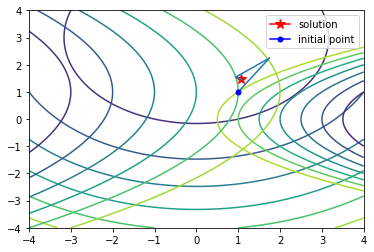

In [44]:
x = np.linspace(-4, 4, 100)
y = np.linspace(-4, 4, 100)

X, Y = np.meshgrid(x, y)

ff = np.array([xx**2 + (yy - 3)**2 for yy in y for xx in x]).reshape(X.shape)
g1 = np.array([-2 * xx + yy **2 for yy in y for xx in x]).reshape(X.shape)
g2 = np.array([5 * xx + (yy - 1)**2 -15 for yy in y for xx in x]).reshape(X.shape)

g1[np.where(g1>0)]= None
g2[np.where(g2>0)]= None
 
trajx = [x[0][0] for x in sol]
trajy = [x[1][0] for x in sol]

trajx.insert(0, 1)
trajy.insert(0, 1)

plt.contour(X, Y, ff)
plt.contour(X, Y, g1)
plt.contour(X, Y, g2)
plt.plot(sol[-1][0][0], sol[-1][1][0], marker = "*", markersize='10', color='red', label='solution')
plt.plot(trajx, trajy)
plt.plot(x0[0][0], x0[1][0], marker ="o", markersize='5', color='blue', label='initial point')
plt.legend()